#Deep learning for optical imaging

###Project: Droplet Impact - Mapping Interferometry to TIR Images (Filtered Data)
This sees whats s going to happen to xx data

by: Ramin Kaviani

Date: 14/12/2020

#Step 0
Reading the compressed file.

In [1]:
# Import python libraries

import sys
sys.path.append('../utils') 

import os
import argparse
import h5py   # HDF5 data file management library
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import skimage
import itertools
import pydot
import graphviz
from IPython.display import Image

from sklearn.model_selection import train_test_split
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model


!cat /proc/cpuinfo
!cat /proc/meminfo
device_lib.list_local_devices()
!nvidia-smi
!nvcc -V
!/usr/bin/python3 --version
tf.__version__



'cat' is not recognized as an internal or external command,
operable program or batch file.
'cat' is not recognized as an internal or external command,
operable program or batch file.
'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.
'nvcc' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


'2.3.1'

In [3]:
magConstant=66000 # Fatal
inputFolderName='./Input/'
outputFolderName='./Output/'

if not os.path.exists(outputFolderName):
    os.makedirs(outputFolderName)

In [4]:
# function to display a grayscale image

def show_image_gray(image, title):

    import matplotlib.pyplot as plt    
    
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.close()
    
    return

def plot_x(y, id):
  ix=28
  iy=112
  a=np.zeros( (ix*iy,1))
  for n in range(ix*iy):
    a[n]=y[id][n]
  a=a.reshape(ix, iy)
  plt.imshow(a,cmap='gray')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.close()

def plot_xx(y, id):
  ix=28
  iy=112
  iz=3
  a=np.zeros( (ix*iy*iz,1))
  for n in range(ix*iy*iz):
    a[n]=y[id][n]
  a=a.reshape(ix, iy, iz)
  b=a[:,:,1]
  plt.imshow(b,cmap='gray')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.close()
    
def plot_y(y, id):
  ix=64
  iy=364
  a=np.zeros( (ix*iy,1))
  for n in range(ix*iy):
    a[n]=y[id][n]
  a=a.reshape(ix, iy)
  plt.imshow(a,cmap='gray')
  plt.grid(None)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.close()


In [45]:
data_path = inputFolderName  
input_data_filename = data_path + 'xx.h5'

hf = h5py.File(input_data_filename, 'r')
temp = hf.get('xx')
input_data1 = np.array(temp)
hf.close()
del temp

print('input_data : ', input_data1.shape, input_data1.dtype)

input_data=np.zeros((input_data1.shape[2],input_data1.shape[1],input_data1.shape[0],3,1),dtype=input_data1.dtype)
      

tmp1 = np.zeros((input_data1.shape[0],input_data1.shape[2]),dtype=input_data1.dtype)      
for j in range(input_data1.shape[1]):
  tmp1= input_data1[:,j,:]
  transpose_tmp1=np.transpose(tmp1)
  input_data[:,j,:,0,0] = transpose_tmp1
  input_data[:,j,:,1,0] = transpose_tmp1
  input_data[:,j,:,2,0] = transpose_tmp1
  
del tmp1 
del input_data1

output_data = pickle.load( open( outputFolderName+'output_data.p', "rb" ) ) # just to check the dims


print('input_data : ', input_data.shape, input_data.dtype)
print('output_data : ', output_data.shape, output_data.dtype)


the_length = 20000 # 20000
the_start= 1
the_end= the_start+ the_length +1

input_data = input_data[1:the_length,:,:,:,:]
output_data = output_data[1:the_length,:,:,:]


print('input_data : ', input_data.shape, input_data.dtype)
print('output_data : ', output_data.shape, output_data.dtype)

n_data_items = input_data.shape[0]
input_xsize = input_data.shape[1]
input_ysize = input_data.shape[2]
input_zsize = 3

output_xsize = output_data.shape[1]
output_ysize = output_data.shape[2]


input_data :  (112, 28, 62920) uint16
input_data :  (62920, 28, 112, 3, 1) uint16
output_data :  (36460, 64, 364, 1) uint16
input_data :  (19999, 28, 112, 3, 1) uint16
output_data :  (19999, 64, 364, 1) uint16


#Design Network
Optimizing the VCC CNN:





In [46]:
file_name=outputFolderName+'modelstructure.h5'
#model.save('/content/gdrive/My Drive/data/modelstructure.h5')
model = keras.models.load_model(file_name)
del output_data

In [47]:
print("Starting prediction");
predict_data = model.predict(input_data)
print('predict_data : ', predict_data.shape, predict_data.dtype)
# del model
# del input_data

print("Prediction Done.")
predict_data_i=(predict_data*magConstant).astype('uint16') 
#print("Multip Done.")
#predict_data_i = predict_data.astype('uint16') 
del predict_data
print("Conversion to int Done.")
predict_data_z = predict_data_i.reshape(n_data_items,output_xsize,output_ysize)
del predict_data_i
print('predict_data_z : ', predict_data_z.shape, predict_data_z.dtype)


Starting prediction
predict_data :  (19999, 23296) float32
Prediction Done.
Conversion to int Done.
predict_data_z :  (19999, 64, 364) uint16


In [48]:
file_name= outputFolderName + 'predict_data_zz.p'
pickle.dump( predict_data_z, open( file_name, "wb" ) )
#input_data = pickle.load (open( outputFolderName+'input_data.p', "rb" ) )
#output_data = pickle.load( open( outputFolderName+'output_data.p', "rb" ) )

file_name= outputFolderName + 'zz.h5'

hf = h5py.File(file_name, 'w')
hf.create_dataset('z', data=predict_data_z)
hf.close()


(19999, 64, 364) uint16


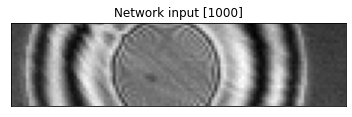

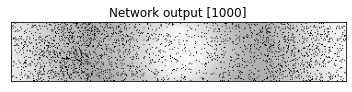

In [50]:
#hf.close()
#del predict_data
print(predict_data_z.shape,predict_data_z.dtype)
data_item = 1000
show_image_gray(input_data[data_item, :, :, 0],  \
                title='Network input [' + str(data_item) + ']')
#show_image_gray(output_data[data_item, :, :, 0],  \
#                title='Target TIR Image[' + str(data_item) + ']')
#plot_y(predict_data,data_item)
show_image_gray(predict_data_z[data_item, :, :],  \
                title='Network output [' + str(data_item) + ']')
#show_image_gray(output_data[data_item-2, :, :, 0],  \
#                title='predicted_data[' + str(data_item) + ']')

In [51]:
del predict_data_z
del input_data
